In [ ]:
!git add

# Debut

In [1]:
def random_float(min=0, max=9):
    import random
    entier = random.randint(min, max)
    float_ = random.random()
    return entier+float_

In [2]:
class Position():
    def __init__(self, longitude, lattitude):
        self.longitude = longitude
        self.lattitude = lattitude
    def __str__(self):
        return "(lon:%s lat:%s)"%(self.longitude, self.lattitude)


# 1) Logger

In [3]:
class Logger():
    def __init__(self, path, bufferlength=1, separator="\n", mode="a"):
        import os
        if os.path.exists(path) :
            msg = "Attention : vous allez utiliser un fichier existant !"
            print (msg)
            if (mode != "a"):
                raise msg
        self.path         = path
        self.logs         = []
        self.bufferlength = bufferlength
        self.separator    = separator

    def clean_msg(self, msg):
        msg = str(msg)
        if msg[-1] != "\n": 
            msg = msg + "\n"
        return msg
    
    def log(self, msg):
        msg = self.clean_msg(msg)
        import datetime
        msg=str(datetime.datetime.now().isoformat())+","+msg
        self.logs.append(msg)
        if self.bufferlength < len(self.logs):
            self.write_to_disk()
    
    def write_to_disk(self):
        with open(self.path, "a") as f:
            f.writelines(self.logs)
        self.logs= []
    
    def __del__(self):
        self.write_to_disk()
                

In [115]:
def get_random_position(x_max, y_max):
    return Position(random_float(0, y_max), random_float(0, y_max))

# 2) Velo

In [409]:
class Velo:
    nb_d_instance =0
    def __init__(self):
        import random
        Velo.nb_d_instance += 1
        self.id             = "velo_%s"%(Velo.nb_d_instance)
        self.performance    = random.random()
    def update_performance(self):
        import numpy as np
        self.performance = np.random.normal(0.75, 0.2)

# 3) Trajet

In [410]:
class Trajet():
    def __init__(self, position_depart, position_arrivee):
        self.depart      = position_depart
        self.destination = position_arrivee
        self.set_position(position_depart)
        self.set_distance() 
        self.set_pas()
        self.avancee_minimale    = 0.4
        
    def set_position(self, position):
        self.longitude   = position.longitude
        self.lattitude   = position.lattitude
        self.position    = position
        
    def set_pas(self):
        delta_longitude    = self.destination.longitude  - self.longitude
        delta_lattitude    = self.destination.lattitude  - self.lattitude
        self.pas_longitude = delta_longitude / float(10)
        self.pas_lattitude = delta_lattitude / float(10)
        
    def set_distance(self):
        import math
        delta_longitude = self.destination.longitude  - self.longitude
        delta_lattitude = self.destination.lattitude  - self.lattitude
        distance        = math.sqrt(math.pow(delta_longitude, 2) + math.pow(delta_lattitude, 2))
        self.distance   = distance
        
    def next_position(self):
        self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            return self.destination
        else:
            new_longitude   = self.longitude + self.pas_longitude
            new_latitude    = self.lattitude + self.pas_lattitude
            new_position    = Position(new_longitude, new_latitude)
            self.set_position(new_position)
            return new_position

# 4) Decaux

In [411]:
class Prestataire():
    def __init__(self, largeur=10, hauteur=10):
        self.largeur = largeur
        self.hauteur = hauteur
        self.reseau = []
        for lattitude in range(self.largeur):
            for longitude in range(self.hauteur):
                emplacement = Position(lattitude, longitude)
                new_station = Station(emplacement)
                self.reseau.append(new_station)
                
    def get_closest_station(self, position):
        nb_ligne = round(position.lattitude)
        nb_col   = round(position.longitude)
        
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        try:
            closest  = self.reseau[int(indice)]
        except:
                closest  = self.reseau[-1]
        return closest
    

    def filtrer_le_reseau(self, function_de_test):
        """
        Renvoie les stations qui passe le test.
        
        Parameters:
            function de test : lambda function
        Return:
            list
        
        """
        return list(filter(function_de_test, self.reseau))
    def nb_station_passant_le_test(self, function):
        r = self.filtrer_le_reseau(function)
        return len(r)
    
    def nombre_de_stations(self):
        return len(self.reseau)
    
    def nombre_de_velos(self):
        return sum(map(lambda x: x.nb_de_velos(),self.reseau))
    
    def nombre_de_stations_pleine(self):
        test  = lambda station: station.nb_bornes == len(station.velos)
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_avec_velo(self):
        test = lambda x: x.has_velo()
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_vide(self):
        test  = lambda station: not station.has_velo()
        return self.nb_station_passant_le_test(test)

    def __str__(self):
        return """
                Nb de stations           : %s 
                Nb de vélos              : %s 
                Nb de stations avec vélo : %s 
                Nb de stations pleines   : %s
                Nb de stations vides     : %s
        """%(self.nombre_de_stations(),
             self.nombre_de_velos(),
             self.nombre_de_stations_avec_velo(),
             self.nombre_de_stations_pleine(),
             self.nombre_de_stations_vide())
    
    def nombre_de_velos_sous_performants(self, seuil=0.5):
        r = map(lambda station: station.nb_velo_under_perf(seuil), self.reseau)
        return sum(list(r))
    def get_topology(self):
        """
        Return a Datframe of longitude/lattitude
        """
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.reseau]}
        
        return pd.DataFrame(infos)
        
        
    

In [414]:
r = Prestataire(3,3)

# 5) Station

In [416]:
class Station:
    nb_d_instance =0
    station_logger=Logger("./stations.csv")
    def __init__(self, position):
        import random
        Station.nb_d_instance +=1
        NB_BORNES_POSSIBLES = [5,10,15,20,30]
        self.position       = position
        self.nb_bornes      = random.choice(NB_BORNES_POSSIBLES)
        self.velos          = [Velo() for i in range(self.nb_bornes)]
        self.id             = Station.nb_d_instance
    
    def nb_de_velos(self):
        return len(self.velos)

    def has_empty_place(self):
        return len(self.velos) < self.nb_bornes

    def has_velo(self):
        return 0 < len(self.velos)
    def log(self, message):
        message="station_%s : %s"%(self.id, message)
        Station.station_logger.log(message)
        
    def deposer_un_velo(self, velo):
        if self.has_empty_place():
            velo.update_performance()
            self.velos.append(velo)
            self.log("recupere le velo %s"%velo.id)
            return True
        else:
            self.log("complete")
            return False
    def prendre_un_velo(self):
        if self.has_velo():
            velo = self.velos.pop()
            self.log("donne le velo %s"%velo.id)
            return velo
        else:
            self.log("vide.")
            return False

    def nb_velo_under_perf(self, seuil_de_performance=0.5):
        test = lambda velo: velo.performance < seuil_de_performance
        return len(list(filter(test, self.velos)))
        

Attention : vous allez utiliser un fichier existant !


# 6) Cycliste

In [417]:
class Cycliste:
    nb_d_instance =0
    cycliste_logger= Logger("./cyclistes.csv")
    def __init__(self, position_home, position_travail, ville):
        import random
        import numpy as np
        Cycliste.nb_d_instance +=1
        self.id           = Cycliste.nb_d_instance
        self.home         = position_home
        self.travail      = position_travail
        self.est_en_route = False
        self.position     = position_home
        self.destination  = position_travail
        self.sur_velo     = False
        self.velo         = False
        self.set_next_trajet()
        self.sexe         = random.choice(["H", "F"])
        self.age          = random.choice(range(15,85))
        self.sportivite   = np.random.normal(2, 2)
        self.ville        = ville
        
        
    def est_a_la_maison(self):
        return self.position == self.home
    def est_au_travail(self):
        return self.position == self.travail
    def est_arrive(self):
        return self.position == self.destination
    
    def log(self, message):
        message="cycliste_%s : %s"%(self.id, message)
        Cycliste.cycliste_logger.log(message)
        
    def trouve_velo(self):
        limite = 10
        while not self.sur_velo and 0 < limite :
            limite         = limite - 1
            station_proche = self.ville.prestataire.get_closest_station(self.position)
            velo           = station_proche.prendre_un_velo()
            self.log("essaie station : %s "%station_proche.id)
            self.position  = station_proche.position 
            if velo:
                self.log("trouve velo %s sur station %s"%(velo.id, station_proche.id))
                self.sur_velo = True # break the loop
                self.velo     = velo
                self.set_next_trajet()
                
                
    def rendre_velo(self):
        limite = 10
        while self.sur_velo and 0 < limite :
            limite         = limite - 1
            station_proche = self.ville.prestataire.get_closest_station(self.position)
            velo_rendu     = station_proche.deposer_un_velo(self.velo)
            self.log("essaie de rendre sur la station : %s "%station_proche.id)
            self.position  = station_proche.position 
            if velo_rendu:
                self.log( "velo rendu sur la station sur : %s"%station_proche.id)
                self.sur_velo = False
                self.velo     = False
                #self.set_next_trajet()
                
    def set_next_trajet(self):
        if self.est_a_la_maison():
            self.log("next trajet = travail")
            self.destination = self.travail
        if self.est_au_travail():
            self.log("next trajet = maison")
            self.destination = self.home
        self.trajet = Trajet(self.position, self.destination)
    
    def ou_suis_je(self):
        if self.est_a_la_maison():
            return " a la maison"
        if self.est_au_travail():
            return " au travail"
        if self.est_en_route():
            return " en route"
    def ou_vais_je(self):
        if self.destination == self.travail:
            return " au travail"
        if self.destination == self.home:
            return " a la maison"
        
    def avancer(self):
        if self.sur_velo:
            self.log( "est sur un velo")
            if self.est_arrive():
                self.log( "est arrive %s(%s)"%(self.ou_suis_je(), self.position.__dict__))
                self.set_next_trajet()
                self.rendre_velo()
            else:
                self.position = self.trajet.next_position()
                self.log( "va a la prochaine position (%s): %s "%(self.ou_vais_je(), self.position.__dict__))
        else:
            self.log( "va chercher un velo")
            self.trouve_velo()
    
            
        

Attention : vous allez utiliser un fichier existant !


In [425]:
class Ville:
    def __init__(self, nb_de_cyclistes, Prestataire):
        self.prestataire = Prestataire
        x_max = Prestataire.largeur -2
        y_max = Prestataire.hauteur-2
        self.cyclistes   = [Cycliste(get_random_position(x_max, y_max), get_random_position(x_max, y_max), self) for i in range(nb_de_cyclistes)]
        self.ax = None
        
    def reveil(self):
        list(map(lambda cycliste : cycliste.avancer(), self.cyclistes))
        
    def get_cycliste_workplaces(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.travail.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.travail.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_cycliste_homes(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.home.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.home.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

        
    def get_cycliste_positions(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.cyclistes],
                  "lattitude"  : [x.position.lattitude for x in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_topology(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.prestataire.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.prestataire.reseau]}
        return pd.DataFrame(infos)
    def get_drawing_data(self):
        cyclistes  = self.get_cycliste_positions()
        stations   = self.get_topology()
        homes      = self.get_cycliste_homes()
        workplaces = self.get_cycliste_workplaces()
        return cyclistes, stations, homes, workplaces

    def draw_map(self,ax=None):
        import matplotlib.pyplot as plt
        cyclistes, stations, homes, workplaces = self.get_drawing_data()
        if not ax:
            ax = stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.4)
        else:
            stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.1, ax=ax)
        homes.plot.scatter(         x="longitudes", y="lattitude", c="green"  , marker="s", ax=ax )
        workplaces.plot.scatter(    x="longitudes", y="lattitude", c="red"    , marker="x", ax=ax )
        cyclistes.plot.scatter(x="longitudes", y="lattitude", c="blue", marker="1"        , ax=ax)
        fig = plt.gcf()
        fig.suptitle(str(cyclistes))
        return ax
        

# 7) Algo

In [426]:
!rm cyclistes.csv


                Nb de stations           : 9 
                Nb de vélos              : 155 
                Nb de stations avec vélo : 9 
                Nb de stations pleines   : 9
                Nb de stations vides     : 0
        


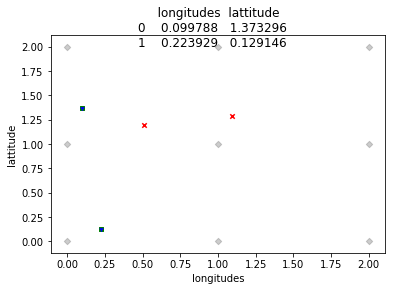

In [428]:
JcDecaux = Prestataire(3,3)
print(JcDecaux)
paris = Ville(2, JcDecaux)
paris.draw_map()

In [408]:
!cat cyclistes.csv

2018-10-19T23:31:53.946339,cycliste_1 : next trajet = travail
2018-10-19T23:31:53.946548,cycliste_2 : next trajet = travail
2018-10-19T23:32:03.081328,cycliste_1 : va chercher un velo
2018-10-19T23:32:03.081421,cycliste_1 : essaie station : 2 
2018-10-19T23:32:03.082215,cycliste_1 : trouve velo velo_6205 sur station 2
2018-10-19T23:32:03.082358,cycliste_2 : va chercher un velo
2018-10-19T23:32:03.082995,cycliste_2 : essaie station : 4 
2018-10-19T23:32:03.083005,cycliste_2 : trouve velo velo_6225 sur station 4
2018-10-19T23:32:03.134590,cycliste_1 : est sur un velo
2018-10-19T23:32:03.134643,cycliste_1 : va a la prochaine position ( au travail): {'longitude': 0.08152235570558167, 'lattitude': 0.9578248254570503} 
2018-10-19T23:32:03.134895,cycliste_2 : est sur un velo
2018-10-19T23:32:03.134916,cycliste_2 : va a la prochaine position ( au travail): {'longitude': 0.9703633436065738, 'lattitude': 0.9105926462777809} 
2018-10-19T23:32:03.180619,cycliste_1 : est sur un velo
2018-10-19T23:3

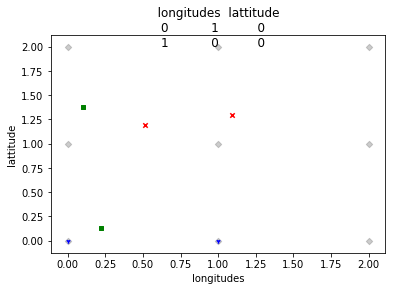

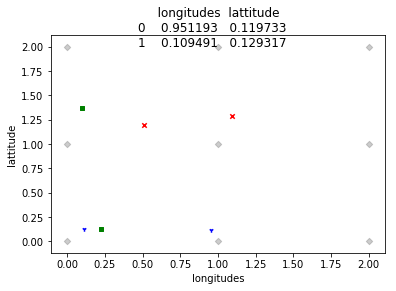

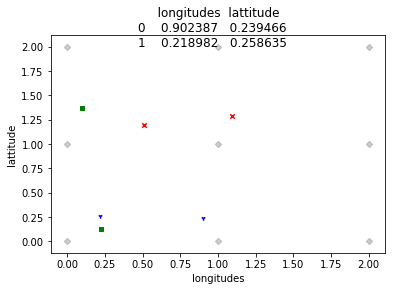

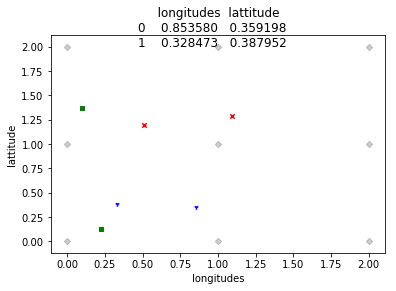

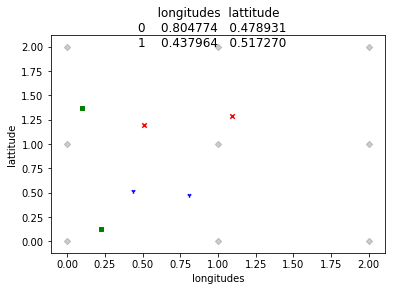

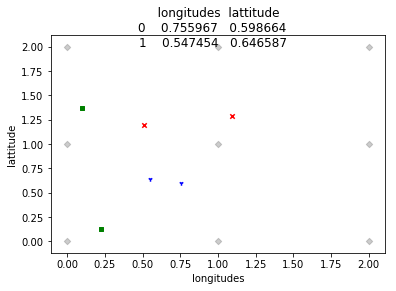

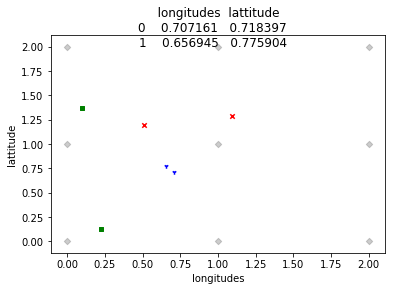

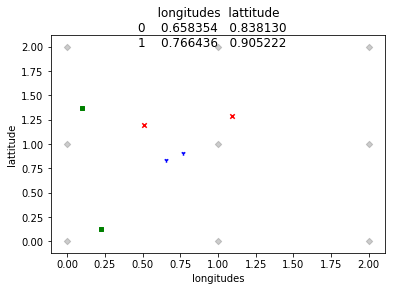

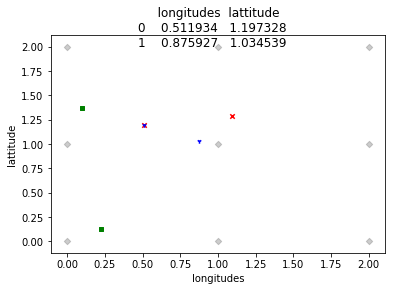

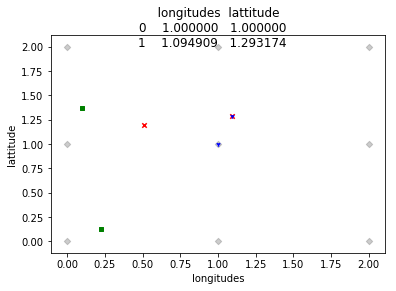

In [430]:
r = {}
for i in range(10):
    paris.reveil()
    paris.draw_map()
    

In [389]:
import pandas as pd

In [390]:
for i in r[j]:
    print(i)

   longitudes  lattitude
0    0.143928   0.434728
1    0.000000   0.000000
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172


In [391]:
type(i)

pandas.core.frame.DataFrame

   longitudes  lattitude
0    0.834931    0.09461
1    0.000000    0.00000
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0    1.000000   0.000000
1    0.806579   0.585172
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0           0          1
1           1          1
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude


/Users/romain/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0    0.000000   1.000000
1    0.266494   0.079486
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude
0           1          0
1           0          0
   longitudes  lattitude
0           0          0
1           0          1
2           1          0
3           1          1
   longitudes  lattitude
0    0.834931   0.094610
1    0.266494   0.079486
   longitudes  lattitude
0    0.143928   0.434728
1    0.806579   0.585172
   longitudes  lattitude


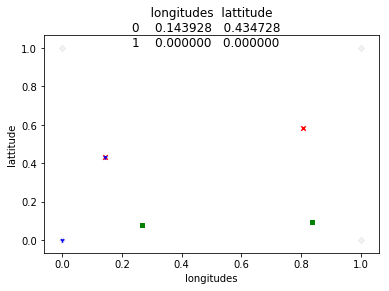

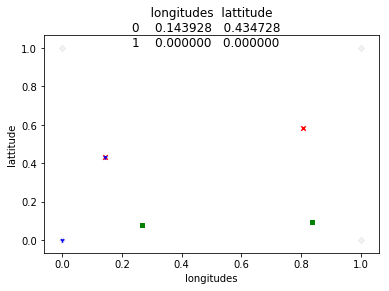

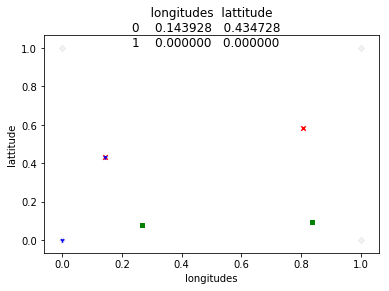

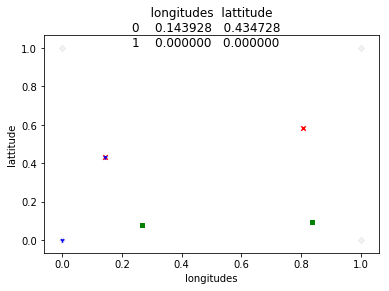

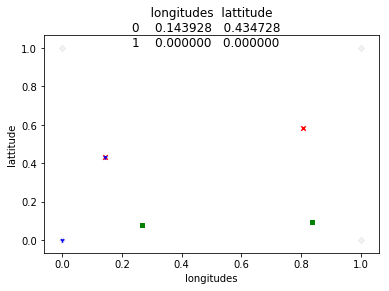

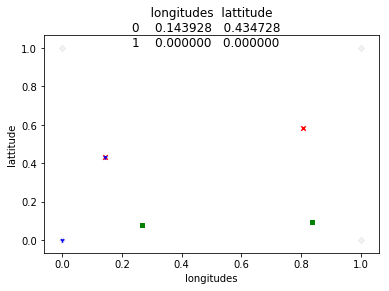

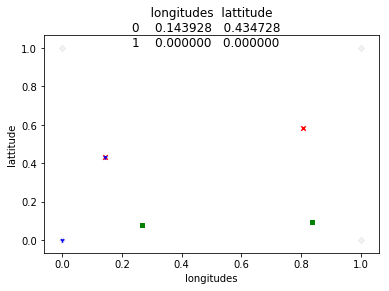

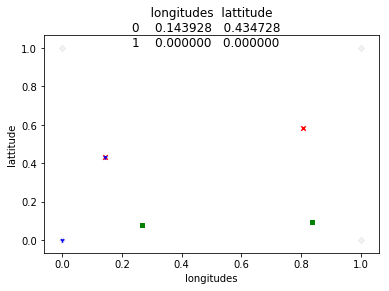

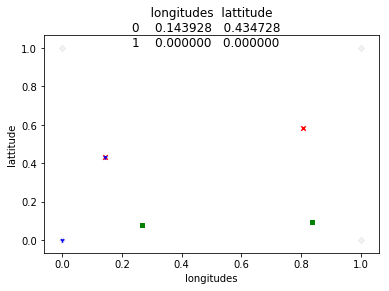

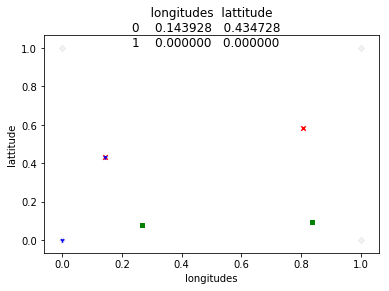

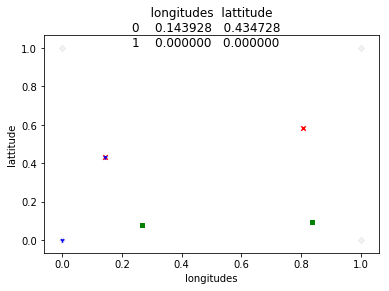

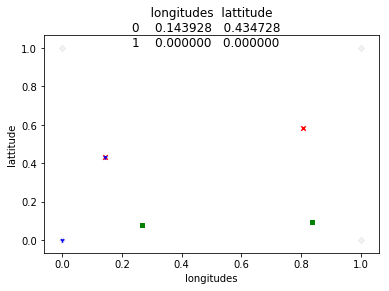

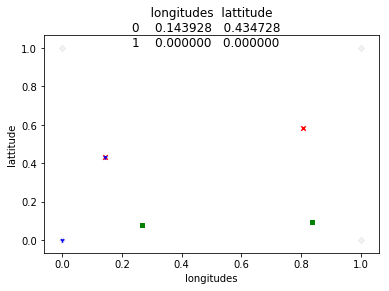

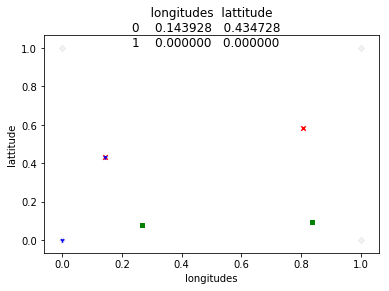

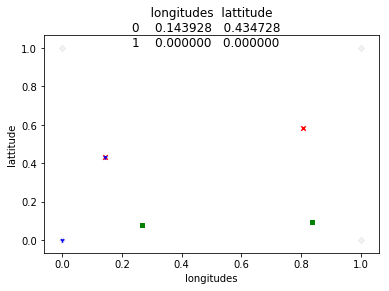

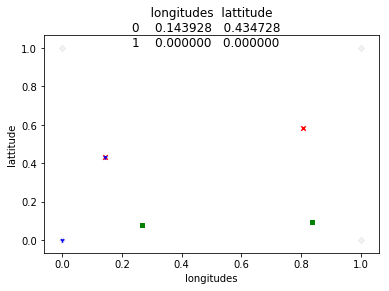

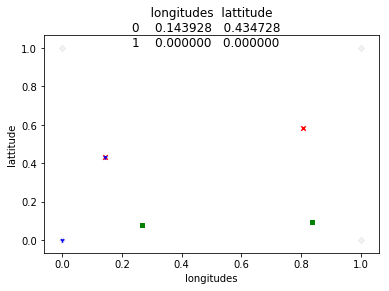

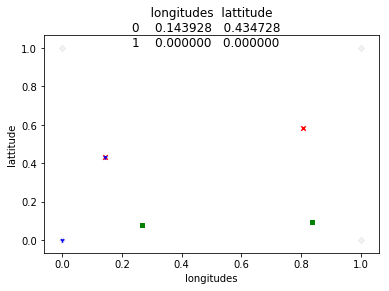

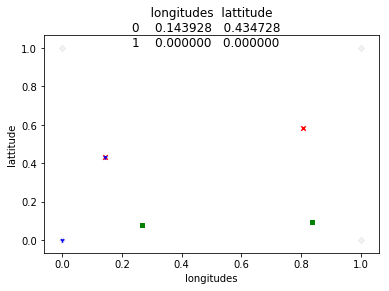

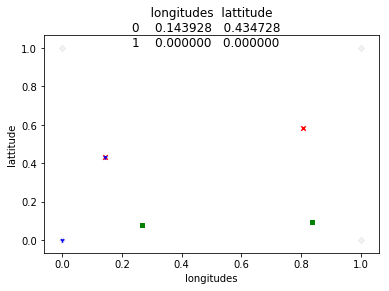

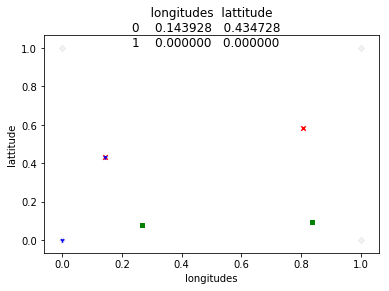

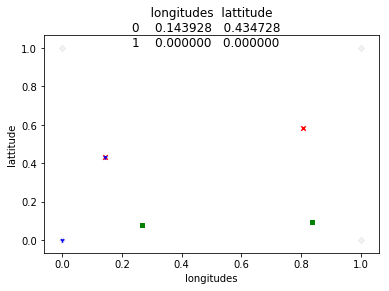

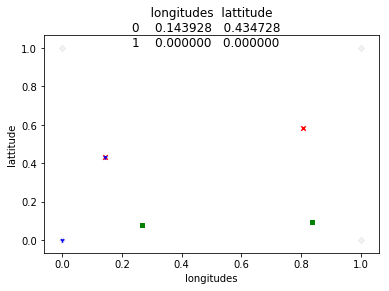

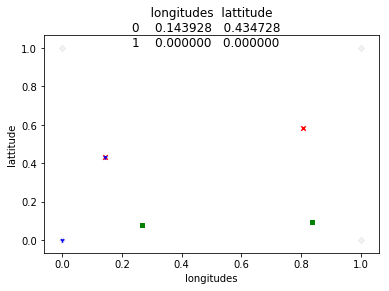

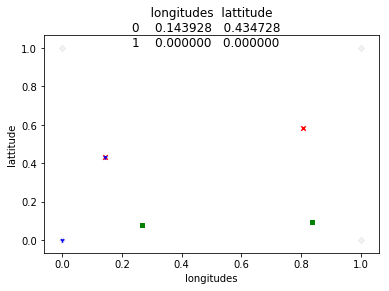

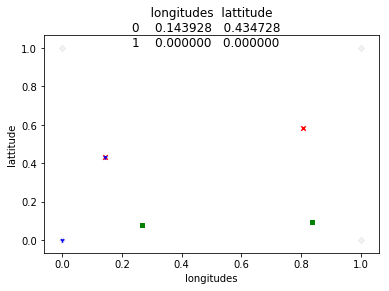

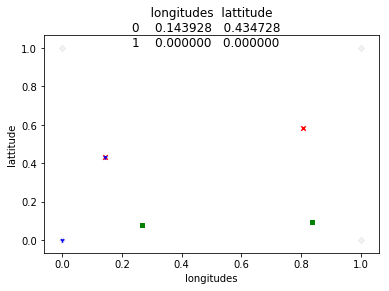

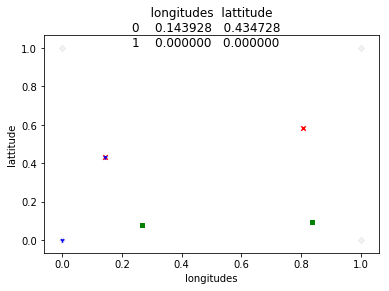

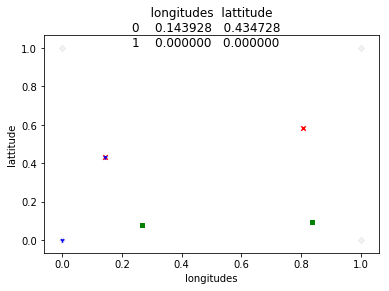

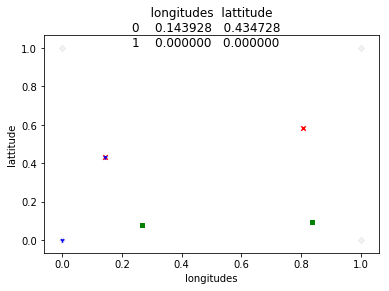

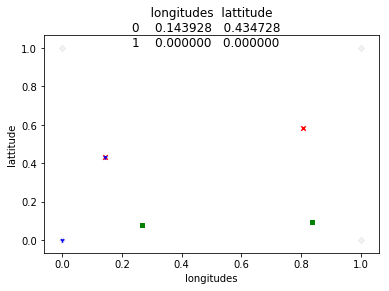

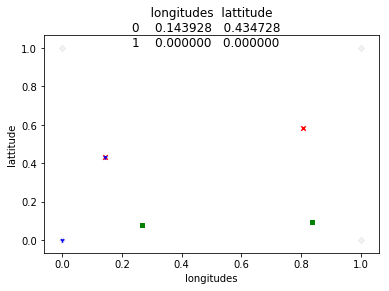

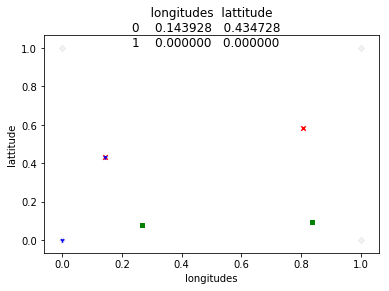

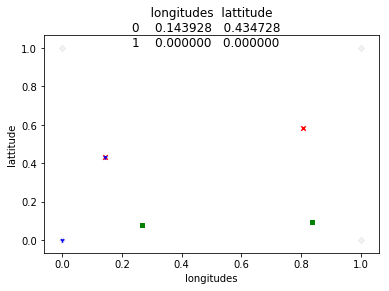

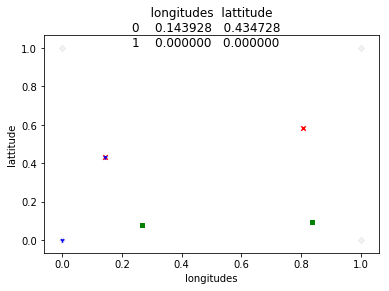

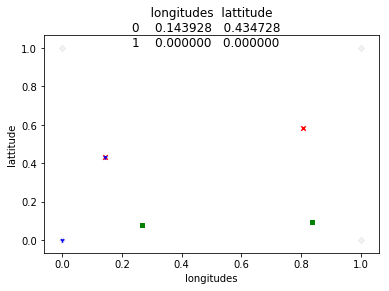

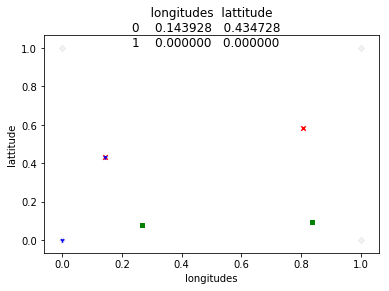

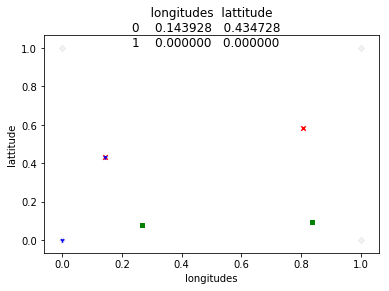

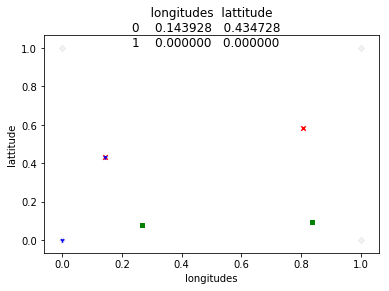

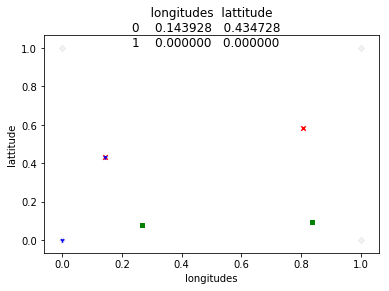

In [395]:
ax = False
for i, j in enumerate(r):
    for a in r[j]:
        print(a)
        if not ax:
            ax=paris.draw_map()
            #ax = a.plot.scatter(x="longitudes", y="lattitude")
        else:
            paris.draw_map(ax)
            a.plot.scatter(x="longitudes", y="lattitude", ax=ax)

,longitudes,lattitude
0,6.390485,8.044468
1,0.516143,4.117503
2,7.739245,7.839961


In [270]:
!tail stations.csv

2018-10-19T22:58:00.760446,station_4 : vide.
2018-10-19T22:58:00.760565,station_4 : vide.
2018-10-19T22:58:00.760707,station_4 : vide.
2018-10-19T22:58:00.760838,station_4 : vide.
2018-10-19T22:58:00.760980,station_4 : vide.
2018-10-19T22:58:00.761111,station_4 : vide.
2018-10-19T22:58:00.761251,station_4 : vide.
2018-10-19T22:58:00.761383,station_4 : vide.
2018-10-19T22:58:00.761524,station_4 : vide.
2018-10-19T22:58:00.761655,station_4 : vide.


In [272]:
!cat cyclistes.csv

id,sexe,sportivite,age,sur_velo
101,F,-0.285718172948,66,True
102,H,2.21944069061,37,True
103,F,2.63725131876,49,True
104,F,1.41355126417,33,True
105,H,-1.33125476053,36,True
106,F,2.85094115743,22,True
107,H,3.33448020505,69,False
108,F,1.83859388938,52,True
109,H,4.74201837628,57,True
110,H,6.41919911825,48,False
111,F,1.79331219549,53,True
112,H,-2.01661124031,84,True
113,H,1.10788330732,55,True
114,H,3.73878208344,23,True
115,F,-1.09865904487,25,True
116,H,-0.100969373183,82,True
117,H,-0.87717813894,57,True
118,F,0.954355558554,40,True
119,H,1.42265760744,35,True
120,H,5.01809539046,65,True
121,F,1.47829758154,19,True
122,F,-0.41804019052,19,True
123,F,-1.66702028236,68,True
124,F,1.72770240039,76,True
125,H,1.9393620796,43,True
126,F,2.27704043074,82,False
127,F,-0.658307398201,67,True
128,H,5.51678303011,23,True
129,H,2.28204558668,56,False
130,F,2.33336855966,75,False
131,H,-2.46890687658,25,True
132,H,4.74619001052,18,True
133,H,2.92544180284,60,True
134,H,3.63988696126,16,Tru

In [269]:
!ls -l

total 50688
-rw-r--r--  1 romain  staff     24218 Dec  1  2017 00_intro_a_pandas_ibm.ipynb
-rw-r--r--  1 romain  staff     13427 Dec  1  2017 00_listes_functions_dictionnaires.ipynb
-rw-r--r--  1 romain  staff    229606 Oct 19 22:58 01_velib.ipynb
-rw-r--r--  1 romain  staff     48007 Dec  1  2017 02_matplotlib_sur_velib.ipynb
-rw-r--r--  1 romain  staff    317220 Dec  1  2017 03_01_scikit_learn_regression_boston.ipynb
-rw-r--r--  1 romain  staff    573391 Dec  1  2017 03_02_scikit_learn_classification_cancer.ipynb
-rw-r--r--  1 romain  staff    322887 Dec  1  2017 03_04_scikit_learn_examples_multi_classe_digits.ipynb
-rw-r--r--  1 romain  staff      3999 Dec  1  2017 04_get_all_csv__find_type_date.ipynb
-rw-r--r--  1 romain  staff    309224 Dec  1  2017 05_example_prediction_Age_sexe_internaute.ipynb
-rw-r--r--  1 romain  staff        77 Dec  1  2017 README.md
-rw-r--r--  1 romain  staff     89134 Dec  1  2017 Untitled.ipynb
-rw-r--r--  1 romain  staff   5787978 Dec  1  2017 adult.raw

In [39]:
!cat cyclistes.csv

id,sexe,sportivite,age,sur_velo
101,F,-0.285718172948,66,True
102,H,2.21944069061,37,True
103,F,2.63725131876,49,True
104,F,1.41355126417,33,True
105,H,-1.33125476053,36,True
106,F,2.85094115743,22,True
107,H,3.33448020505,69,False
108,F,1.83859388938,52,True
109,H,4.74201837628,57,True
110,H,6.41919911825,48,False
111,F,1.79331219549,53,True
112,H,-2.01661124031,84,True
113,H,1.10788330732,55,True
114,H,3.73878208344,23,True
115,F,-1.09865904487,25,True
116,H,-0.100969373183,82,True
117,H,-0.87717813894,57,True
118,F,0.954355558554,40,True
119,H,1.42265760744,35,True
120,H,5.01809539046,65,True
121,F,1.47829758154,19,True
122,F,-0.41804019052,19,True
123,F,-1.66702028236,68,True
124,F,1.72770240039,76,True
125,H,1.9393620796,43,True
126,F,2.27704043074,82,False
127,F,-0.658307398201,67,True
128,H,5.51678303011,23,True
129,H,2.28204558668,56,False
130,F,2.33336855966,75,False
131,H,-2.46890687658,25,True
132,H,4.74619001052,18,True
133,H,2.92544180284,60,True
134,H,3.63988696126,16,Tru

In [366]:
!cat stations.csv

station_27 : donne le velo velo_6655
station_165 : donne le velo velo_8935
station_187 : donne le velo velo_9280
station_183 : donne le velo velo_9195
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete


In [311]:
if False:
    path_to_cyclistes = "./cyclistes.csv"
    logger_ = Logger(path_to_cyclistes)
    infos_voulues = ["id", "sexe", "sportivite", "age", "sur_velo"]
    to_write      = ",".join(infos_voulues)
    logger_.log(to_write)
    for cycliste in paris.cyclistes:
        dico          = cycliste.__dict__        
        infos         = [str(dico[voulue]) for voulue in infos_voulues]
        to_write      = ",".join(infos)
        logger_.log(to_write)


Attention : vous allez utiliser un fichier existant !


# Exemple de dataFrame pandas

In [313]:
logger_.write_to_disk()


In [308]:
import pandas as pd

In [309]:
dico = {}
for i in range(12):
    seuil       = float(i/10)
    nb_velo     = test_reseau.nombre_de_velos_sous_performants(seuil)
    dico[seuil] = nb_velo

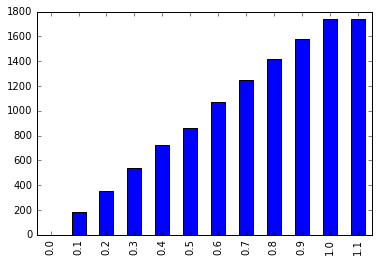

In [310]:
%matplotlib inline
pd.DataFrame(dico, index=range(12)).T[0].plot(kind='bar')